In [1]:
# 데이터 처리 및 시각화을 위한 모듈 import
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
# 변수 선정을 위한 모듈
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
# FaceBook에서 오픈 소스로 공개한 시계열 데이터 분석 및 예측 라이브러리 (Prophet)
from prophet import Prophet

In [2]:
# Prophet 라이브러리의 출력을 정리하는 데 사용되는 클래스.
class suppress_stdout_stderr(object):
    def __init__(self):
        # 한 쌍의 null 파일을 open.
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # 실제 stdout(1) 및 stderr(2)의 file descriptor 저장.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # stdout 및 stderr에 null pointer 할당.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # 실제 stdout와 stderr을 (1)과 (2)에 다시 할당.
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])


## 데이터 정리 및 전처리

In [3]:
# 1차 전처리된 cn7 및 rg3 데이터 파일 load
df_cn7 = pd.read_csv('cn7.csv', index_col=0)
df_rg3 = pd.read_csv('rg3.csv', index_col=0)

In [4]:
# TimeStamp를 인덱스로 설정하여 데이터를 시계열 시퀀스로 처리
df_cn7['TimeStamp'] = pd.to_datetime(df_cn7['TimeStamp'])
df_cn7 = df_cn7.set_index('TimeStamp')

df_rg3['TimeStamp'] = pd.to_datetime(df_rg3['TimeStamp'])
df_rg3 = df_rg3.set_index('TimeStamp')

# 데이터를 연속적인 시계열로 더 쉽게 처리하고 분할하기 위해 일 열을 추가
df_cn7['day']=df_cn7.index.to_period('D')
df_rg3['day']=df_rg3.index.to_period('D')


# 매일 얼마나 많은 데이터 포인트가 있는지 확인
print("datapoints we have on each day For CN7:\n", df_cn7.day.value_counts())
print("datapoints we have on each day For RG3:\n", df_rg3.day.value_counts())

datapoints we have on each day For CN7:
 2020-11-03    463
2020-10-20    382
2020-10-30    373
2020-10-27    314
2020-10-29    224
2020-10-16    187
2020-10-19     36
Freq: D, Name: day, dtype: int64
datapoints we have on each day For RG3:
 2020-10-22    300
2020-10-23    250
2020-10-21     41
2020-11-04     35
2020-11-05      1
Freq: D, Name: day, dtype: int64


In [5]:
# CN7의 데이터는 7개의 날짜로 나뉘므로 데이터를 일 단위인 7개의 시계열로 나눈다.
ts1_cn7 = df_cn7.loc[df_cn7.day== '2020-10-16']
ts1_cn7.reset_index(inplace=True)
ts2_cn7 = df_cn7.loc[df_cn7.day== '2020-10-19']
ts2_cn7.reset_index(inplace=True)
ts3_cn7 = df_cn7.loc[df_cn7.day== '2020-10-20']
ts3_cn7.reset_index(inplace=True)
ts4_cn7 = df_cn7.loc[df_cn7.day== '2020-10-27']
ts4_cn7.reset_index(inplace=True)
ts5_cn7 = df_cn7.loc[df_cn7.day== '2020-10-29']
ts5_cn7.reset_index(inplace=True)
ts6_cn7 = df_cn7.loc[df_cn7.day== '2020-10-30']
ts6_cn7.reset_index(inplace=True)
ts7_cn7 = df_cn7.loc[df_cn7.day== '2020-11-03']
ts7_cn7.reset_index(inplace=True)


# RG3의 데이터는 4개의 날짜로 나뉘므로 데이터를 일 단위인 4개의 시계열로 나눈다. (11월 5일은 데이터가 1개뿐이므로 제외)
ts1_rg3 = df_rg3.loc[df_rg3.day== '2020-10-21']
ts1_rg3.reset_index(inplace=True)
ts2_rg3 = df_rg3.loc[df_rg3.day== '2020-10-22']
ts2_rg3.reset_index(inplace=True)
ts3_rg3 = df_rg3.loc[df_rg3.day== '2020-10-23']
ts3_rg3.reset_index(inplace=True)
ts4_rg3 = df_rg3.loc[df_rg3.day== '2020-11-04']
ts4_rg3.reset_index(inplace=True)

## 변수 선정

In [12]:
# SelectKBest 클래스를 적용하여 최적의 변수 추출

x = df_cn7.drop(['PassOrFail','PART_FACT_PLAN_DATE','day'], axis=1) # 숫자타입이 아닌 컬럼 삭제
y = df_cn7['PassOrFail']
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
bestfeatures = SelectKBest(score_func=chi2, k=3)
fit = bestfeatures.fit(x_scaled, y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Feature', 'Score']
print(featureScores.nlargest(5, 'Score'))

               Feature     Score
23  Mold_Temperature_4  4.910802
0       Injection_Time  3.220529
22  Mold_Temperature_3  3.061031
10   Average_Screw_RPM  2.188221
1         Filling_Time  0.514241


# *CN7 W/S SIDE MLD'G* 예측

## 시계열별 Injection_Time 예측

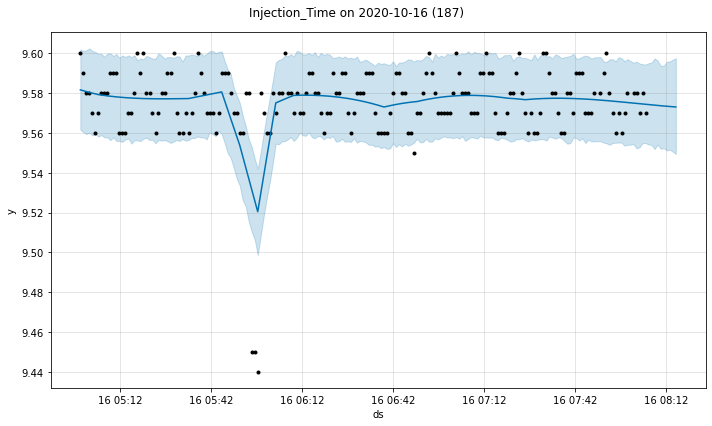

In [117]:
# 첫 번째 시계열에 대한 시각화
# TimeStamp는 'ds', 변수는 'y'인 두 개의 열만 있는 Prophet에 적용하기 위한 새 데이터 프레임 생성
# prophet은 입력 형식에 대해 엄격하기 때문에 제안된 대로 수행하는 것이 중요

pro = pd.DataFrame()

pro['ds'] = ts1_cn7['TimeStamp']
pro['y'] = ts1_cn7['Injection_Time']

# 모델 선언 후 모델 fit
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)

# 다음 10개의 timestep에 대한 예측
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

# 실제 값과 예측 값 시각화
fig1=m.plot(forecast)
fig1.suptitle('Injection_Time on 2020-10-16 ({})'.format(len(pro)))
fig1.tight_layout()

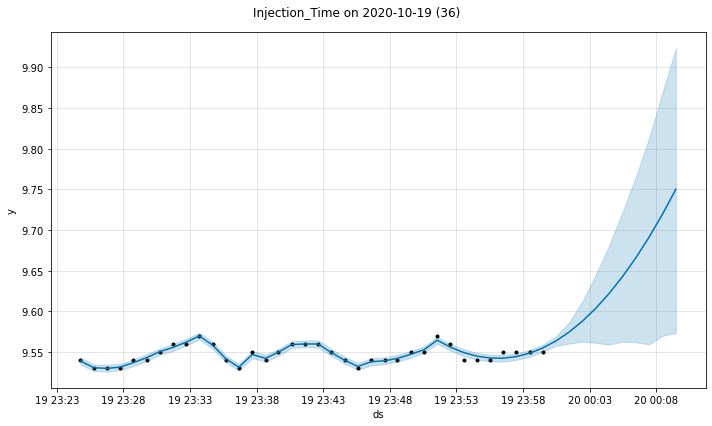

In [118]:
# 두 번째 시계열에 대한 시각화
pro = pd.DataFrame()

pro['ds'] = ts2_cn7['TimeStamp']
pro['y'] = ts2_cn7['Injection_Time']

with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1=m.plot(forecast)
fig1.suptitle('Injection_Time on 2020-10-19 ({})'.format(len(pro)))
fig1.tight_layout()

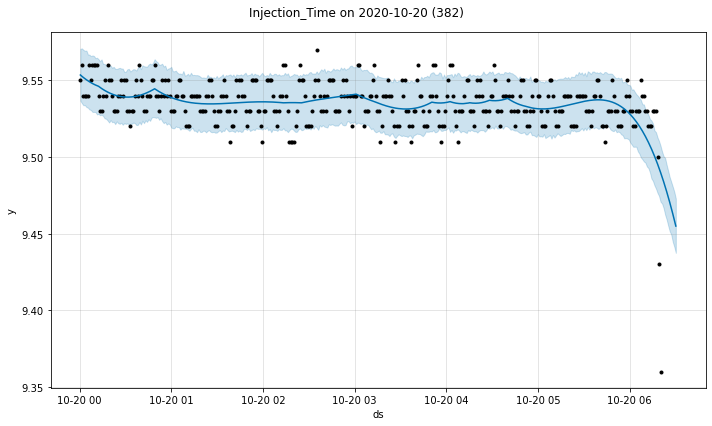

In [119]:
# 세 번째 시계열에 대한 시각화
pro = pd.DataFrame()

pro['ds'] = ts3_cn7['TimeStamp']
pro['y'] = ts3_cn7['Injection_Time']

with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1=m.plot(forecast)
fig1.suptitle('Injection_Time on 2020-10-20 ({})'.format(len(pro)))
fig1.tight_layout()

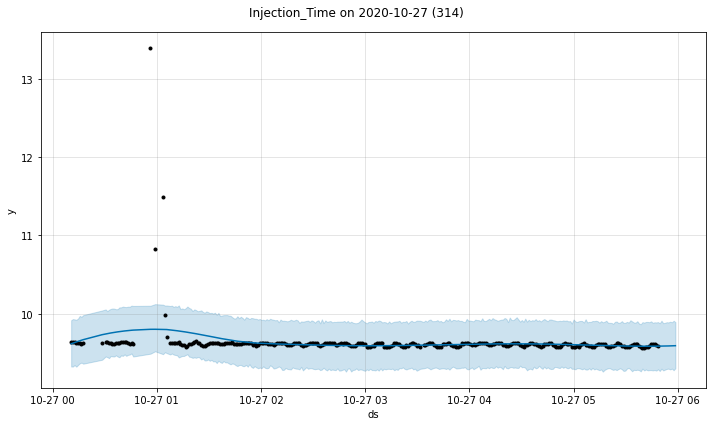

In [120]:
# 네 번째 시계열에 대한 시각화
pro = pd.DataFrame()

pro['ds'] = ts4_cn7['TimeStamp']
pro['y'] = ts4_cn7['Injection_Time']

with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1=m.plot(forecast)
fig1.suptitle('Injection_Time on 2020-10-27 ({})'.format(len(pro)))
fig1.tight_layout()

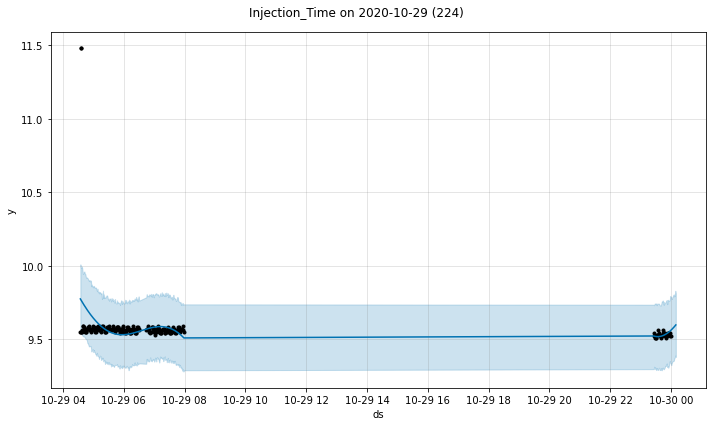

In [121]:
# 다섯 번째 시계열에 대한 시각화
pro = pd.DataFrame()

pro['ds'] = ts5_cn7['TimeStamp']
pro['y'] = ts5_cn7['Injection_Time']

with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1=m.plot(forecast)
fig1.suptitle('Injection_Time on 2020-10-29 ({})'.format(len(pro)))
fig1.tight_layout()

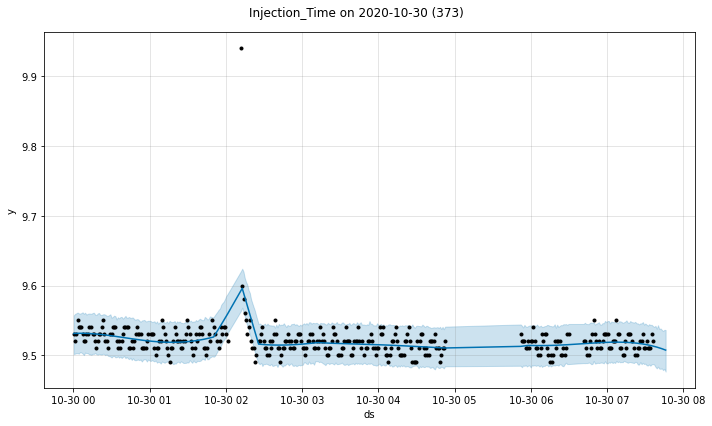

In [122]:
# 여섯 번째 시계열에 대한 시각화
pro = pd.DataFrame()

pro['ds'] = ts6_cn7['TimeStamp']
pro['y'] = ts6_cn7['Injection_Time']

with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1=m.plot(forecast)
fig1.suptitle('Injection_Time on 2020-10-30 ({})'.format(len(pro)))
fig1.tight_layout()

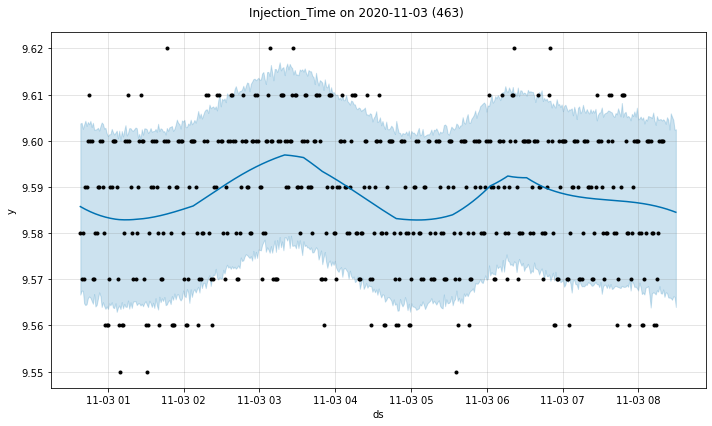

In [123]:
# 일곱 번째 시계열에 대한 시각화
pro = pd.DataFrame()

pro['ds'] = ts7_cn7['TimeStamp']
pro['y'] = ts7_cn7['Injection_Time']

with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1=m.plot(forecast)
fig1.suptitle('Injection_Time on 2020-11-03 ({})'.format(len(pro)))
fig1.tight_layout()

## 시계열별 Average_Screw_RPM 예측

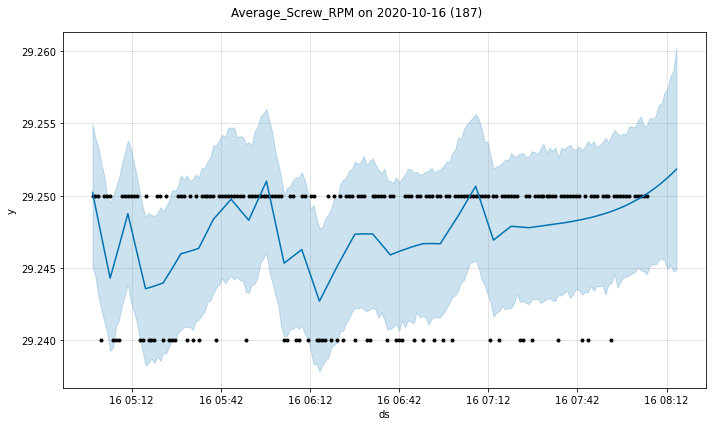

In [124]:
# 첫 번째 시계열에 대한 시각화

pro = pd.DataFrame()

pro['ds'] = ts1_cn7['TimeStamp']

# Average_Screw_RPM 값의 소수점 위치에 오류가 있는 것 같으니 10으로 나누어 나머지 데이터와 균일하게 만든다.
pro['y'] = ts1_cn7['Average_Screw_RPM']/10 

with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)

future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1=m.plot(forecast)
fig1.suptitle('Average_Screw_RPM on 2020-10-16 ({})'.format(len(pro)))
fig1.tight_layout()

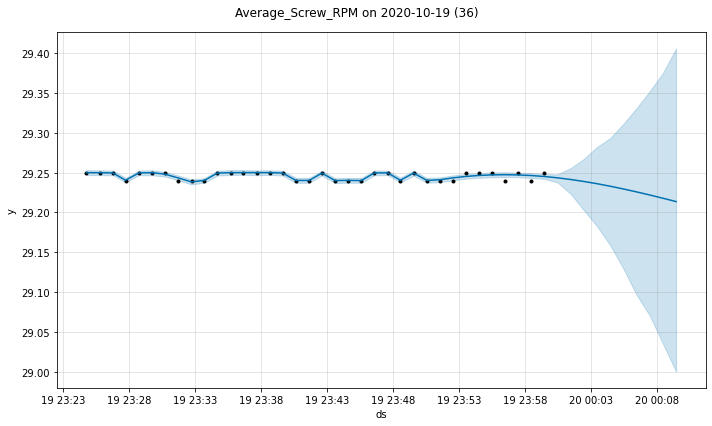

In [125]:
# 두 번째 시계열에 대한 시각화
pro = pd.DataFrame()

pro['ds'] = ts2_cn7['TimeStamp']
pro['y'] = ts1_cn7['Average_Screw_RPM']/10 

with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)

future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1=m.plot(forecast)
fig1.suptitle('Average_Screw_RPM on 2020-10-19 ({})'.format(len(pro)))
fig1.tight_layout()

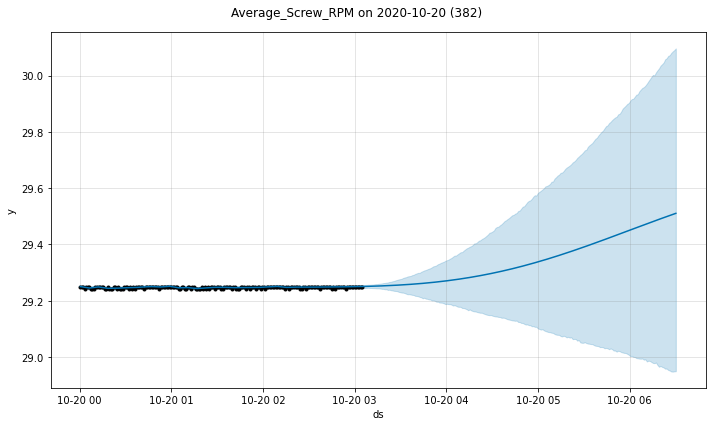

In [126]:
# 세 번째 시계열에 대한 시각화
pro = pd.DataFrame()

pro['ds'] = ts3_cn7['TimeStamp']
pro['y'] = ts1_cn7['Average_Screw_RPM']/10 

with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1=m.plot(forecast)
fig1.suptitle('Average_Screw_RPM on 2020-10-20 ({})'.format(len(pro)))
fig1.tight_layout()

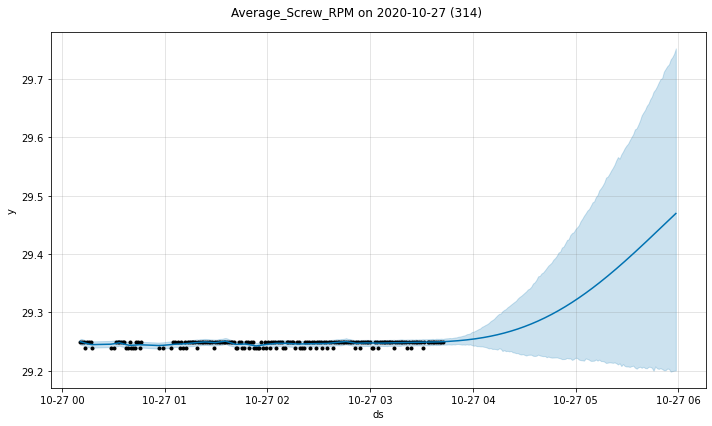

In [127]:
# 네 번째 시계열에 대한 시각화
pro = pd.DataFrame()

pro['ds'] = ts4_cn7['TimeStamp']
pro['y'] = ts1_cn7['Average_Screw_RPM']/10 

with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)

future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1=m.plot(forecast)
fig1.suptitle('Average_Screw_RPM on 2020-10-27 ({})'.format(len(pro)))
fig1.tight_layout()

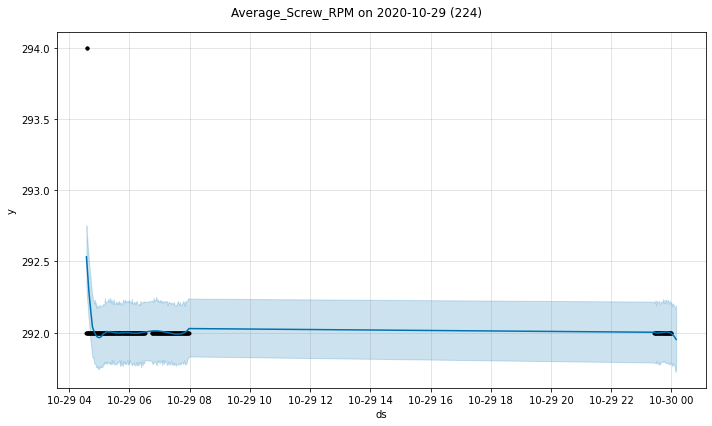

In [128]:
# 다섯 번째 시계열에 대한 시각화
pro = pd.DataFrame()

pro['ds'] = ts5_cn7['TimeStamp']
pro['y'] = ts5_cn7['Average_Screw_RPM']

with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)

future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1=m.plot(forecast)
fig1.suptitle('Average_Screw_RPM on 2020-10-29 ({})'.format(len(pro)))
fig1.tight_layout()

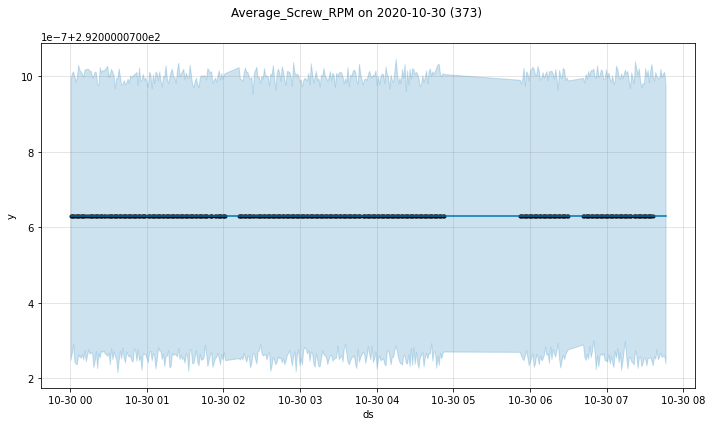

In [129]:
# 여섯 번째 시계열에 대한 시각화
pro = pd.DataFrame()

pro['ds'] = ts6_cn7['TimeStamp']
pro['y'] = ts6_cn7['Average_Screw_RPM']

with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1=m.plot(forecast)
fig1.suptitle('Average_Screw_RPM on 2020-10-30 ({})'.format(len(pro)))
fig1.tight_layout()

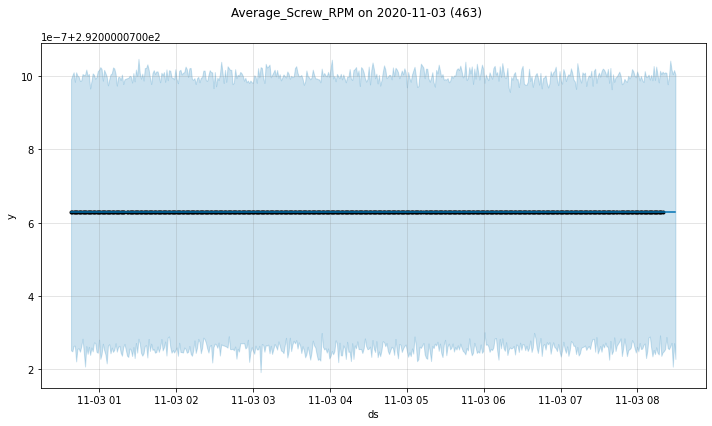

In [130]:
# 일곱 번째 시계열에 대한 시각화
pro = pd.DataFrame()

pro['ds'] = ts7_cn7['TimeStamp']
pro['y'] = ts7_cn7['Average_Screw_RPM']

with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)

future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1=m.plot(forecast)
fig1.suptitle('Average_Screw_RPM on 2020-11-03 ({})'.format(len(pro)))
fig1.tight_layout()

## 시계열별 Plasticizing_Time 예측

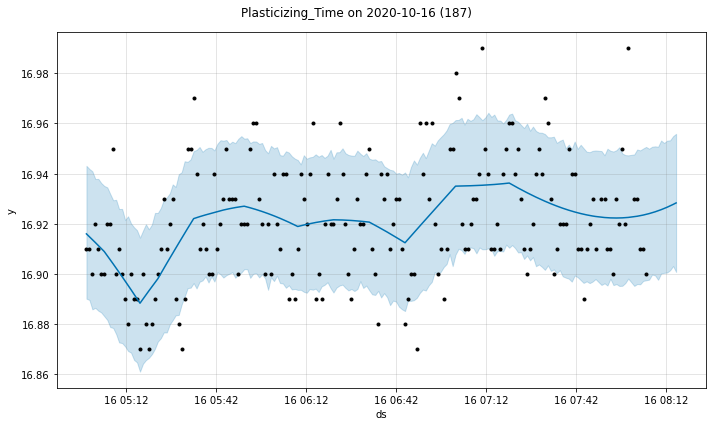

In [131]:
#Plotting for the First Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested

pro = pd.DataFrame()

pro['ds'] = ts1_cn7['TimeStamp']
pro['y'] = ts1_cn7['Plasticizing_Time']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)

#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Plasticizing_Time on 2020-10-16 ({})'.format(len(pro)))
fig1.tight_layout()


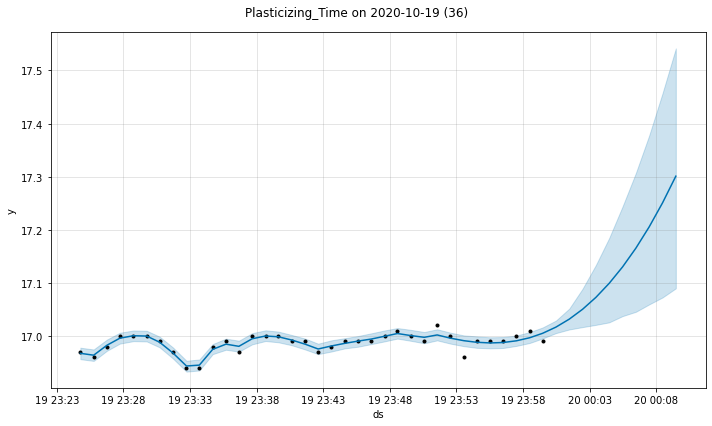

In [132]:
##Plotting for the Second Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts2_cn7['TimeStamp']
pro['y'] = ts2_cn7['Plasticizing_Time']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Plasticizing_Time on 2020-10-19 ({})'.format(len(pro)))
fig1.tight_layout()


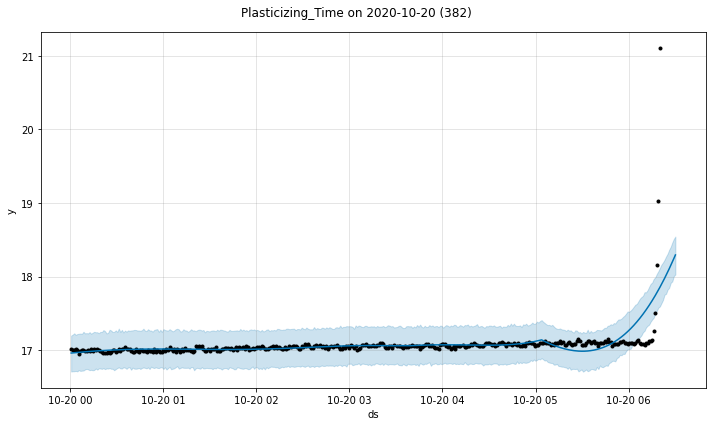

In [133]:
##Plotting for the Third Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts3_cn7['TimeStamp']
pro['y'] = ts3_cn7['Plasticizing_Time']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Plasticizing_Time on 2020-10-20 ({})'.format(len(pro)))
fig1.tight_layout()


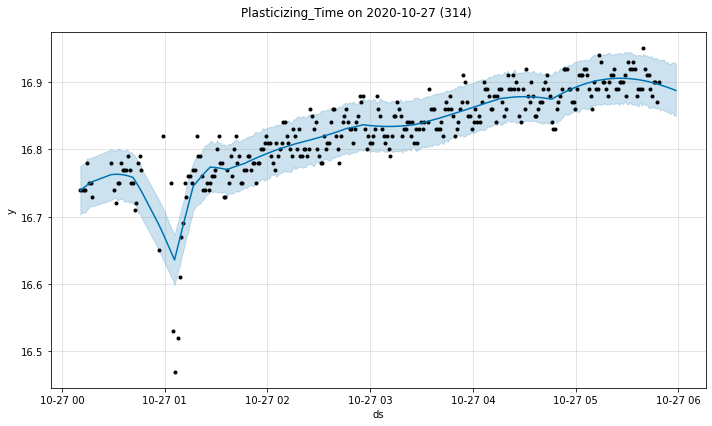

In [134]:
##Plotting for the Fourth Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts4_cn7['TimeStamp']
pro['y'] = ts4_cn7['Plasticizing_Time']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Plasticizing_Time on 2020-10-27 ({})'.format(len(pro)))
fig1.tight_layout()


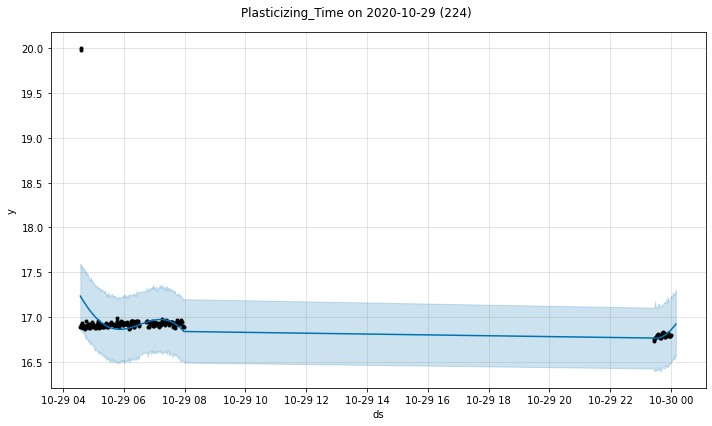

In [135]:
##Plotting for the Fifth Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts5_cn7['TimeStamp']
pro['y'] = ts5_cn7['Plasticizing_Time']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Plasticizing_Time on 2020-10-29 ({})'.format(len(pro)))
fig1.tight_layout()


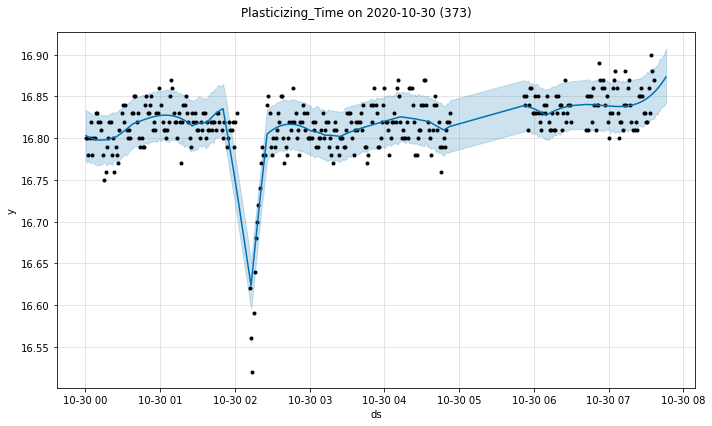

In [136]:
##Plotting for the Sixth Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts6_cn7['TimeStamp']
pro['y'] = ts6_cn7['Plasticizing_Time']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Plasticizing_Time on 2020-10-30 ({})'.format(len(pro)))
fig1.tight_layout()


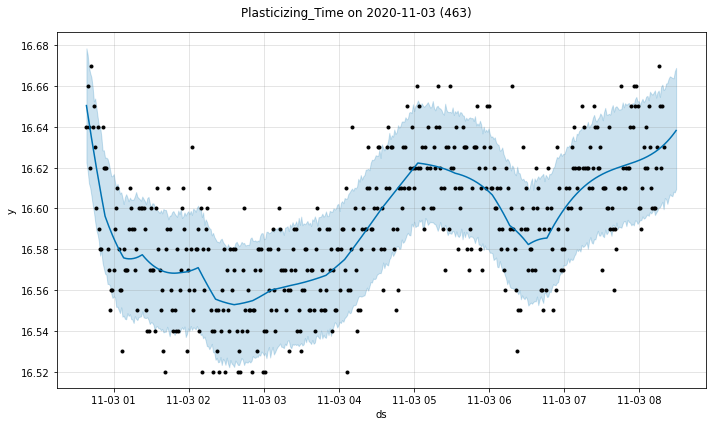

In [137]:
##Plotting for the Seventh Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts7_cn7['TimeStamp']
pro['y'] = ts7_cn7['Plasticizing_Time']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Plasticizing_Time on 2020-11-03 ({})'.format(len(pro)))
fig1.tight_layout()



Plasticizing_Time

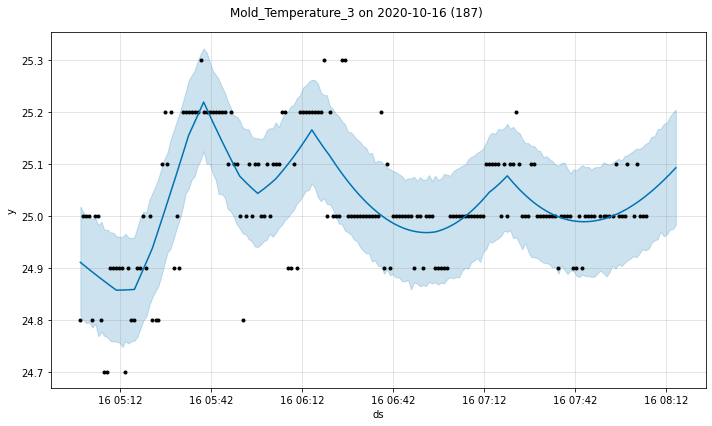

In [138]:
#Plotting for the First Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested

pro = pd.DataFrame()

pro['ds'] = ts1_cn7['TimeStamp']
pro['y'] = ts1_cn7['Mold_Temperature_3']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)

#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Mold_Temperature_3 on 2020-10-16 ({})'.format(len(pro)))
fig1.tight_layout()


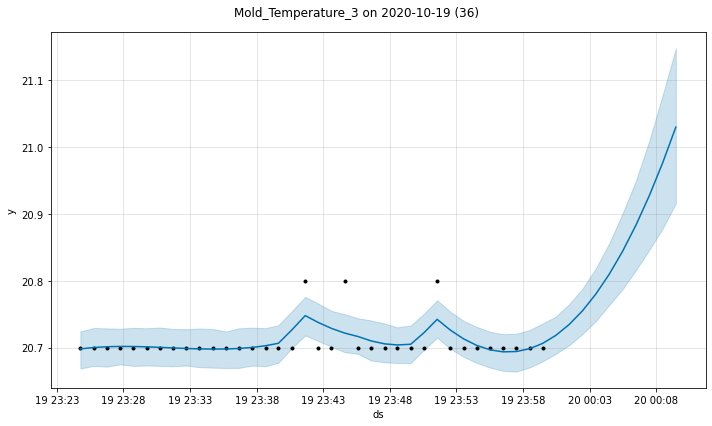

In [139]:
##Plotting for the Second Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts2_cn7['TimeStamp']
pro['y'] = ts2_cn7['Mold_Temperature_3']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Mold_Temperature_3 on 2020-10-19 ({})'.format(len(pro)))
fig1.tight_layout()


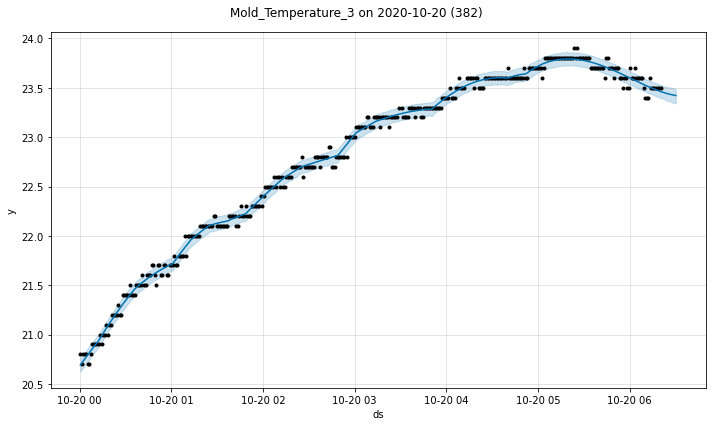

In [140]:
##Plotting for the Third Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts3_cn7['TimeStamp']
pro['y'] = ts3_cn7['Mold_Temperature_3']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Mold_Temperature_3 on 2020-10-20 ({})'.format(len(pro)))
fig1.tight_layout()


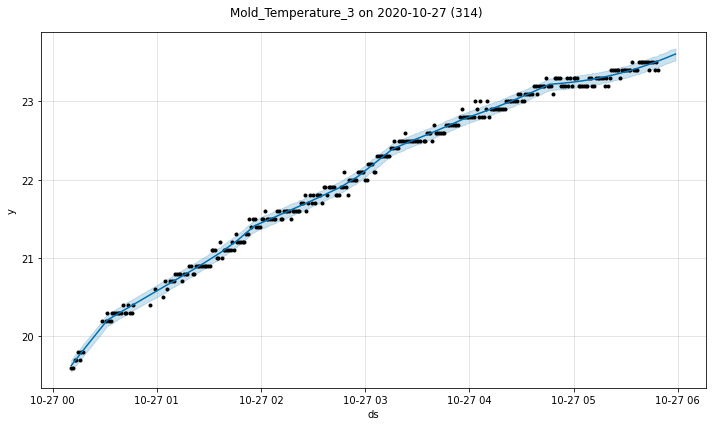

In [141]:
##Plotting for the Fourth Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts4_cn7['TimeStamp']
pro['y'] = ts4_cn7['Mold_Temperature_3']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Mold_Temperature_3 on 2020-10-27 ({})'.format(len(pro)))
fig1.tight_layout()


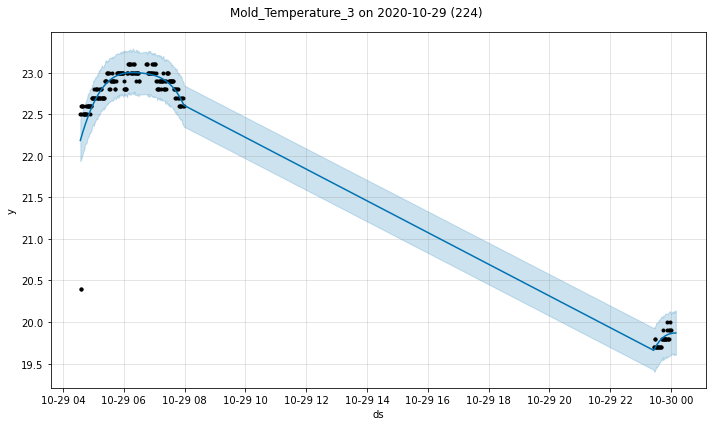

In [142]:
##Plotting for the Fifth Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts5_cn7['TimeStamp']
pro['y'] = ts5_cn7['Mold_Temperature_3']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Mold_Temperature_3 on 2020-10-29 ({})'.format(len(pro)))
fig1.tight_layout()


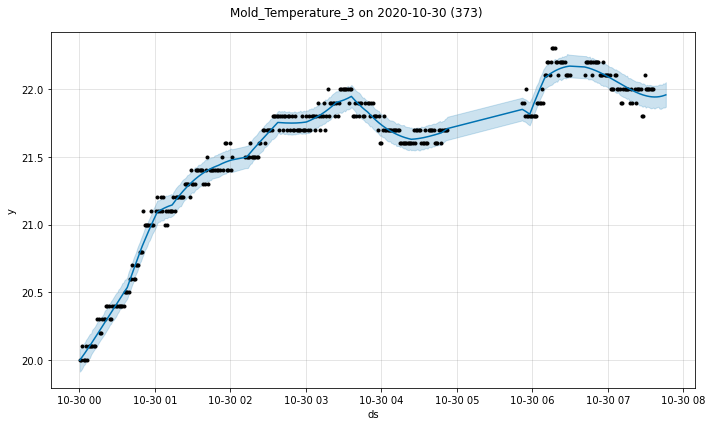

In [143]:
##Plotting for the Sixth Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts6_cn7['TimeStamp']
pro['y'] = ts6_cn7['Mold_Temperature_3']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Mold_Temperature_3 on 2020-10-30 ({})'.format(len(pro)))
fig1.tight_layout()


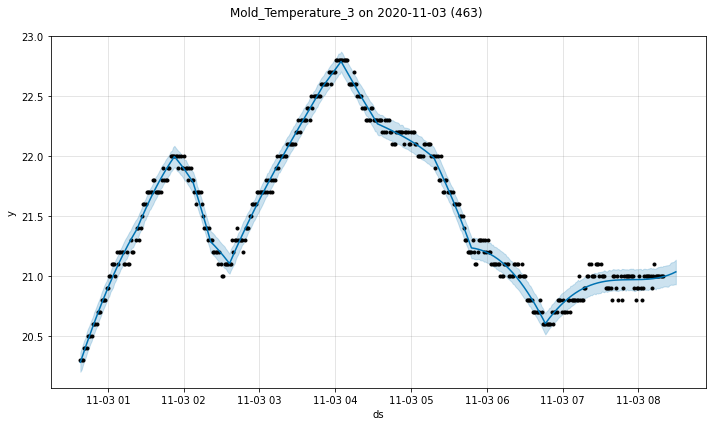

In [144]:
##Plotting for the Seventh Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts7_cn7['TimeStamp']
pro['y'] = ts7_cn7['Mold_Temperature_3']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Mold_Temperature_3 on 2020-11-03 ({})'.format(len(pro)))
fig1.tight_layout()



## 시계열별 Mold_Temperature_4 예측

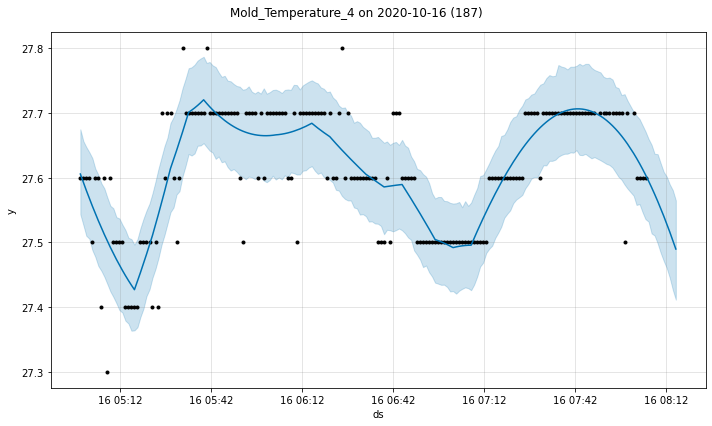

In [145]:
#Plotting for the First Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested

pro = pd.DataFrame()

pro['ds'] = ts1_cn7['TimeStamp']
pro['y'] = ts1_cn7['Mold_Temperature_4']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)

#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Mold_Temperature_4 on 2020-10-16 ({})'.format(len(pro)))
fig1.tight_layout()


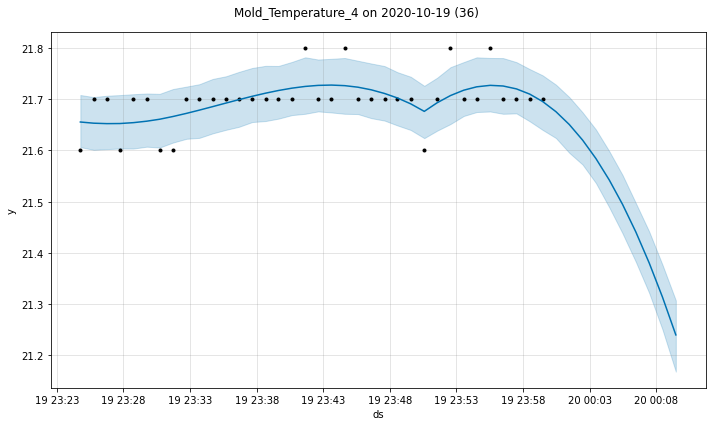

In [146]:
##Plotting for the Second Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts2_cn7['TimeStamp']
pro['y'] = ts2_cn7['Mold_Temperature_4']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Mold_Temperature_4 on 2020-10-19 ({})'.format(len(pro)))
fig1.tight_layout()


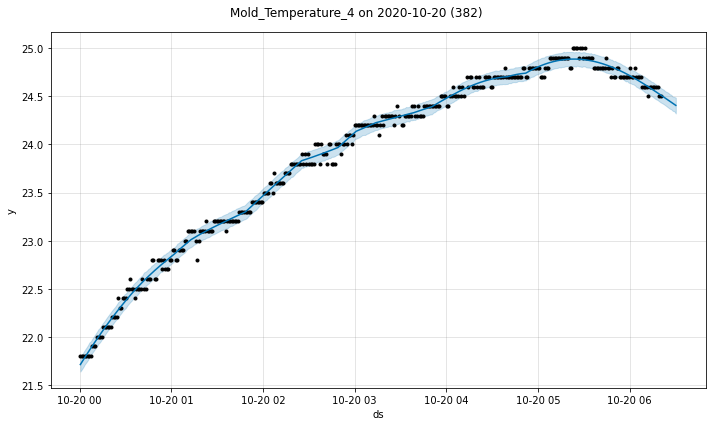

In [147]:
##Plotting for the Third Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts3_cn7['TimeStamp']
pro['y'] = ts3_cn7['Mold_Temperature_4']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Mold_Temperature_4 on 2020-10-20 ({})'.format(len(pro)))
fig1.tight_layout()


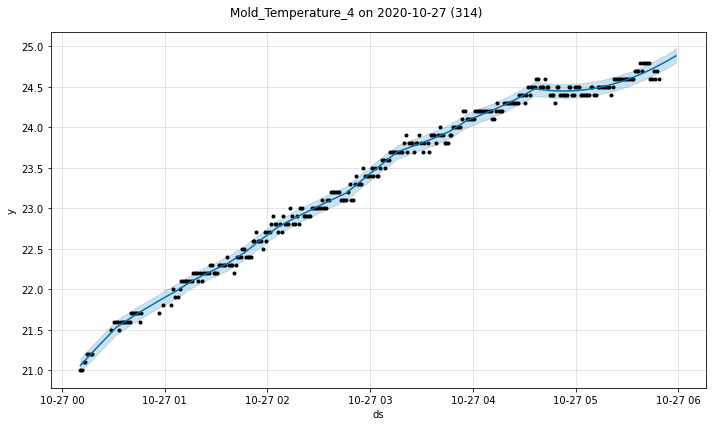

In [148]:
##Plotting for the Fourth Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts4_cn7['TimeStamp']
pro['y'] = ts4_cn7['Mold_Temperature_4']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Mold_Temperature_4 on 2020-10-27 ({})'.format(len(pro)))
fig1.tight_layout()


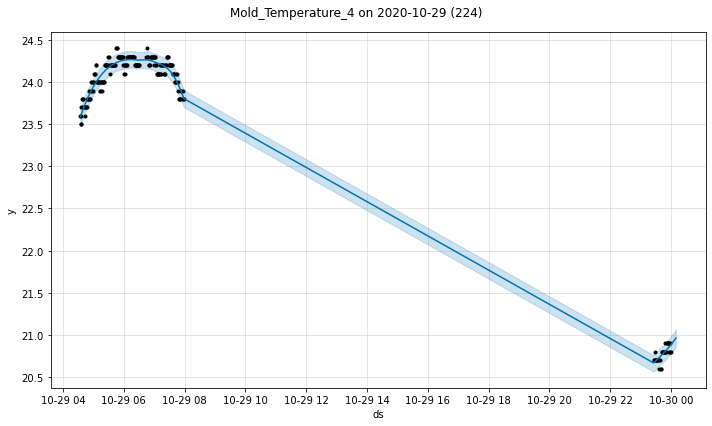

In [149]:
##Plotting for the Fifth Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts5_cn7['TimeStamp']
pro['y'] = ts5_cn7['Mold_Temperature_4']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Mold_Temperature_4 on 2020-10-29 ({})'.format(len(pro)))
fig1.tight_layout()


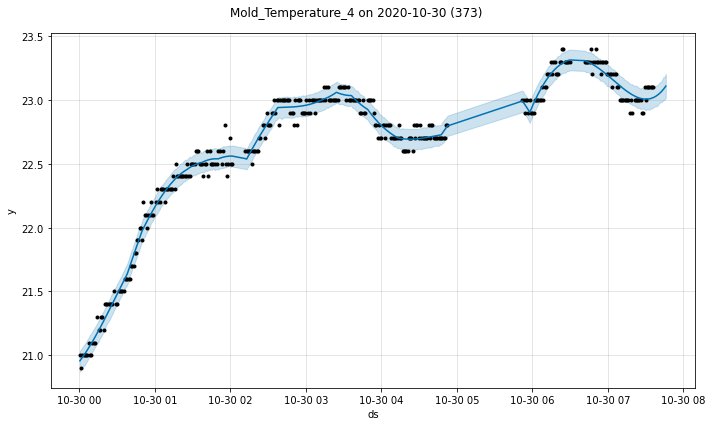

In [150]:
##Plotting for the Sixth Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts6_cn7['TimeStamp']
pro['y'] = ts6_cn7['Mold_Temperature_4']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Mold_Temperature_4 on 2020-10-30 ({})'.format(len(pro)))
fig1.tight_layout()


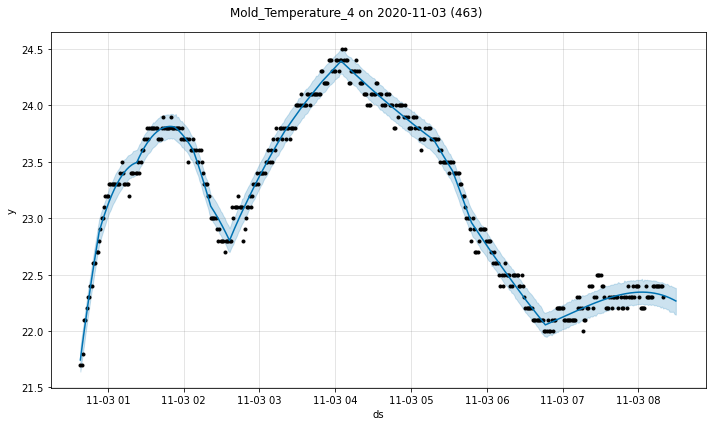

In [151]:
##Plotting for the Seventh Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts7_cn7['TimeStamp']
pro['y'] = ts7_cn7['Mold_Temperature_4']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Mold_Temperature_4 on 2020-11-03 ({})'.format(len(pro)))
fig1.tight_layout()



## 시계열별 Max_Injection_Speed 예측

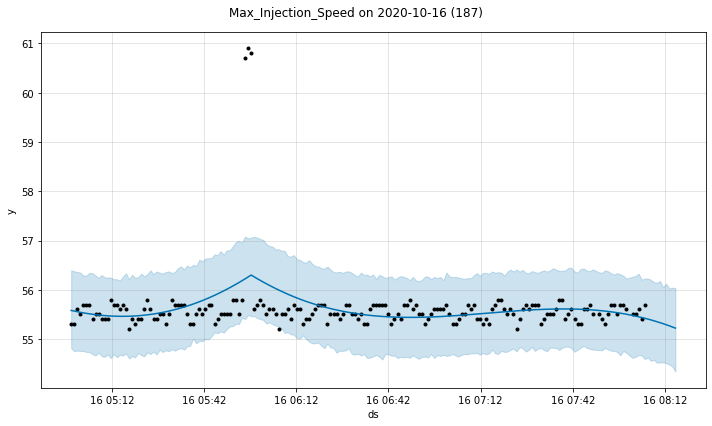

In [152]:
#Plotting for the First Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested

pro = pd.DataFrame()

pro['ds'] = ts1_cn7['TimeStamp']
pro['y'] = ts1_cn7['Max_Injection_Speed']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)

#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Max_Injection_Speed on 2020-10-16 ({})'.format(len(pro)))
fig1.tight_layout()


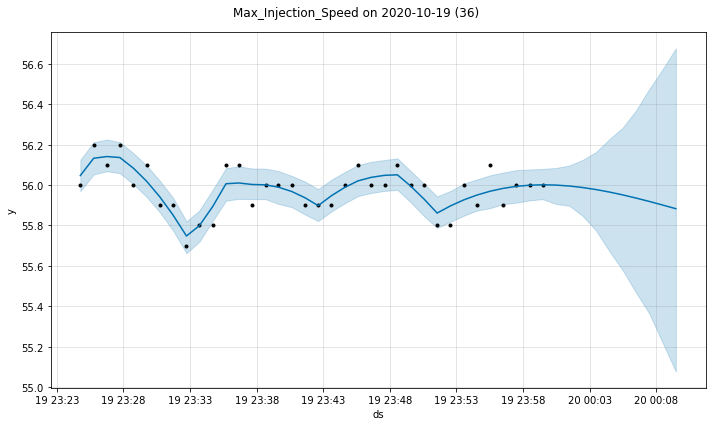

In [153]:
##Plotting for the Second Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts2_cn7['TimeStamp']
pro['y'] = ts2_cn7['Max_Injection_Speed']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Max_Injection_Speed on 2020-10-19 ({})'.format(len(pro)))
fig1.tight_layout()


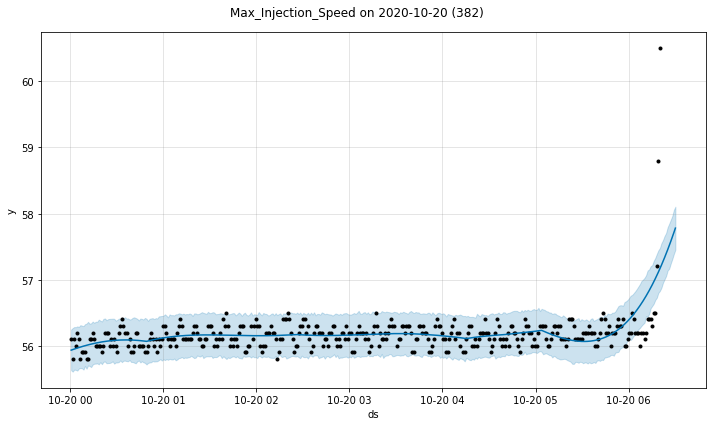

In [154]:
##Plotting for the Third Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts3_cn7['TimeStamp']
pro['y'] = ts3_cn7['Max_Injection_Speed']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Max_Injection_Speed on 2020-10-20 ({})'.format(len(pro)))
fig1.tight_layout()


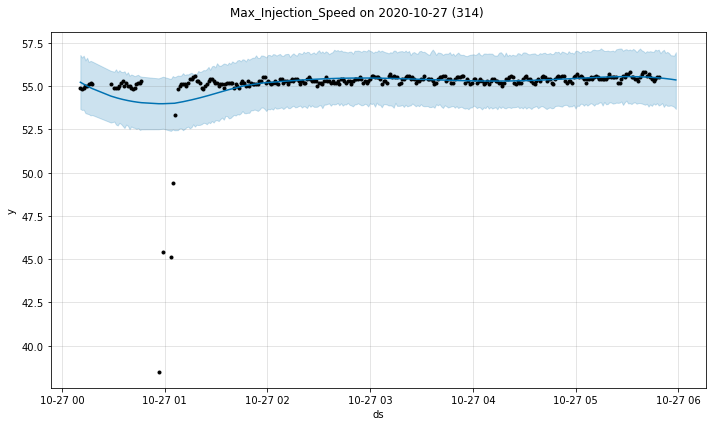

In [155]:
##Plotting for the Fourth Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts4_cn7['TimeStamp']
pro['y'] = ts4_cn7['Max_Injection_Speed']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Max_Injection_Speed on 2020-10-27 ({})'.format(len(pro)))
fig1.tight_layout()


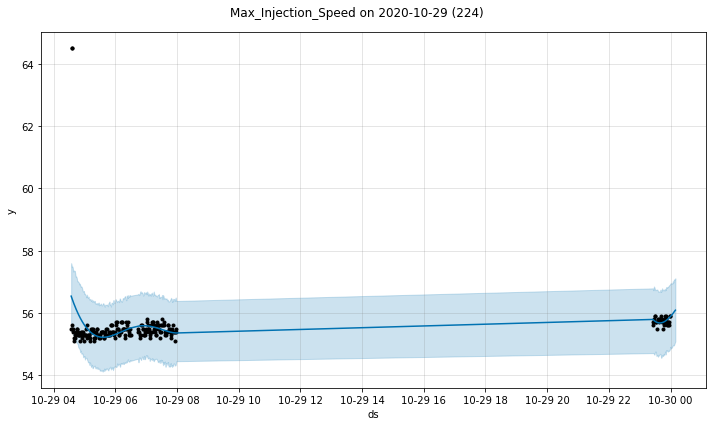

In [156]:
##Plotting for the Fifth Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts5_cn7['TimeStamp']
pro['y'] = ts5_cn7['Max_Injection_Speed']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Max_Injection_Speed on 2020-10-29 ({})'.format(len(pro)))
fig1.tight_layout()


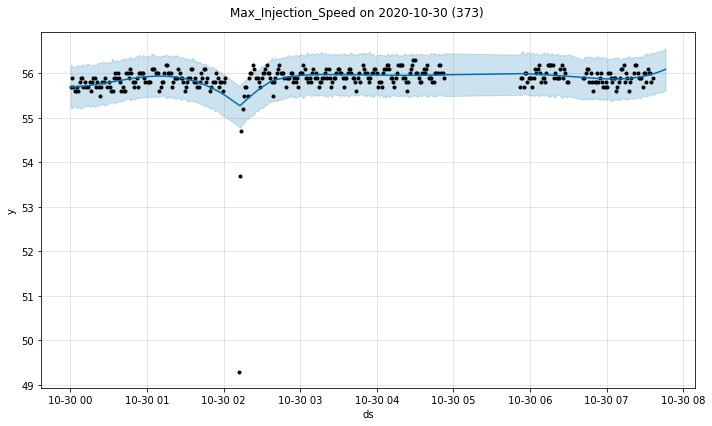

In [157]:
##Plotting for the Sixth Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts6_cn7['TimeStamp']
pro['y'] = ts6_cn7['Max_Injection_Speed']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Max_Injection_Speed on 2020-10-30 ({})'.format(len(pro)))
fig1.tight_layout()


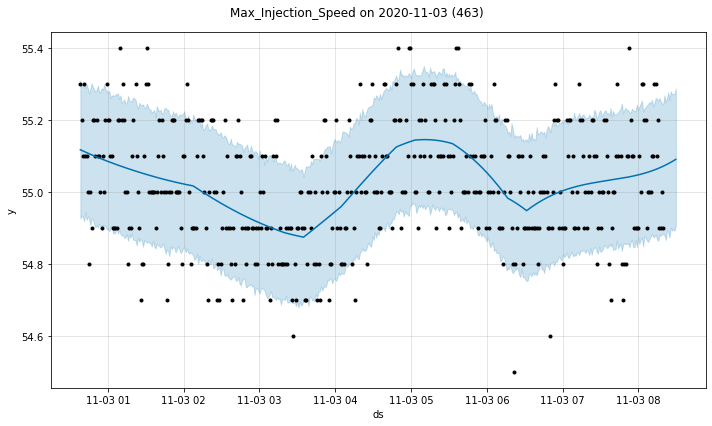

In [158]:
##Plotting for the Seventh Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts7_cn7['TimeStamp']
pro['y'] = ts7_cn7['Max_Injection_Speed']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Max_Injection_Speed on 2020-11-03 ({})'.format(len(pro)))
fig1.tight_layout()



# *RG3 MOLD'G W/SHLD* 예측

## 시계열별 Injection_Time 예측

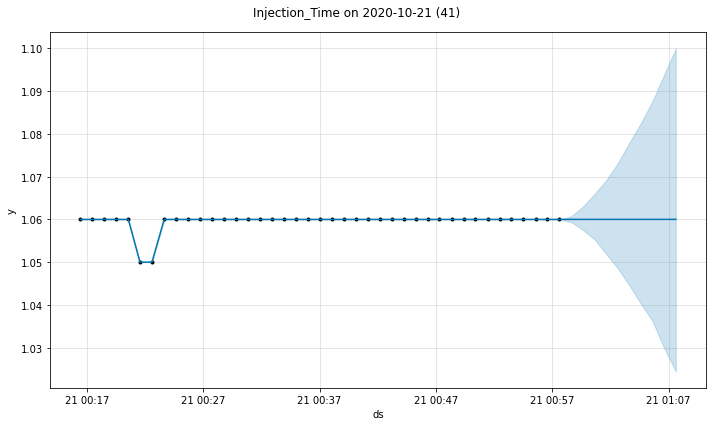

In [159]:
#Plotting for the First Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested

pro = pd.DataFrame()

pro['ds'] = ts1_rg3['TimeStamp']
pro['y'] = ts1_rg3['Injection_Time']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)

#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Injection_Time on 2020-10-21 ({})'.format(len(pro)))
fig1.tight_layout()


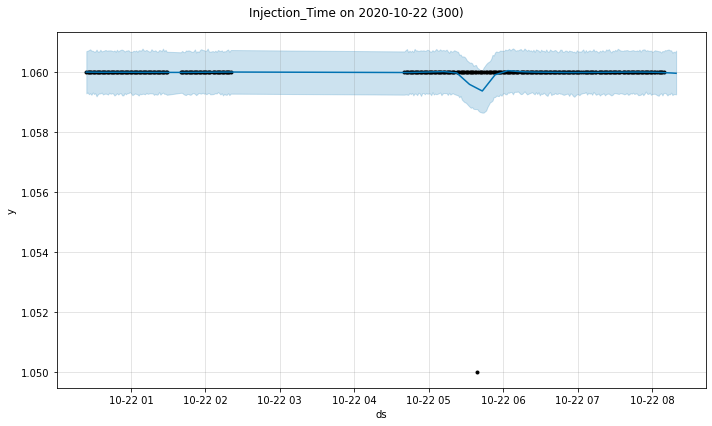

In [160]:
##Plotting for the Second Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts2_rg3['TimeStamp']
pro['y'] = ts2_rg3['Injection_Time']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Injection_Time on 2020-10-22 ({})'.format(len(pro)))
fig1.tight_layout()


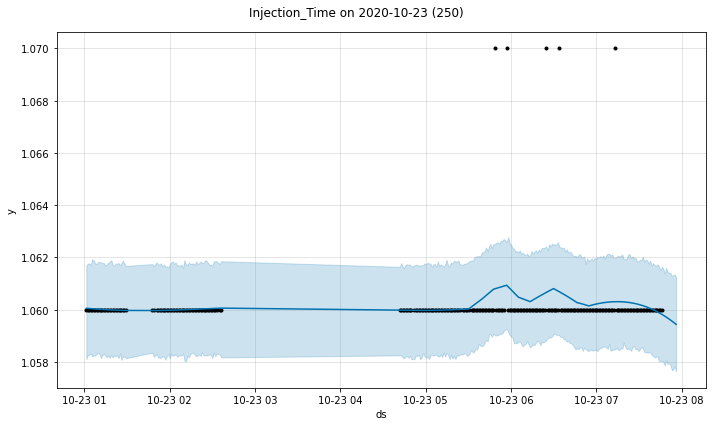

In [161]:
##Plotting for the Third Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts3_rg3['TimeStamp']
pro['y'] = ts3_rg3['Injection_Time']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Injection_Time on 2020-10-23 ({})'.format(len(pro)))
fig1.tight_layout()


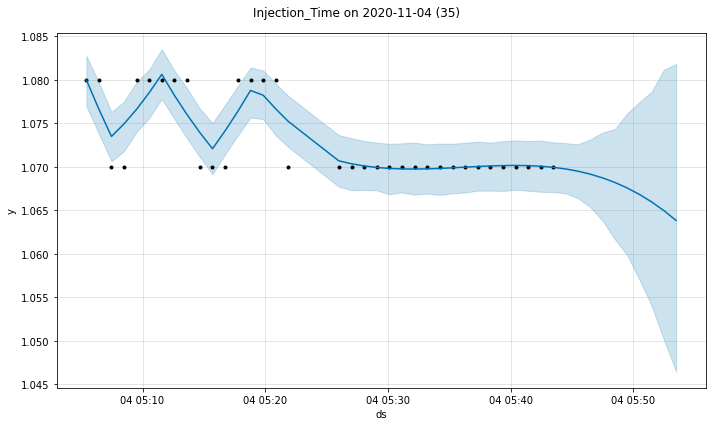

In [162]:
##Plotting for the Fourth Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts4_rg3['TimeStamp']
pro['y'] = ts4_rg3['Injection_Time']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Injection_Time on 2020-11-04 ({})'.format(len(pro)))
fig1.tight_layout()


## 시계열별 Average_Screw_RPM 예측

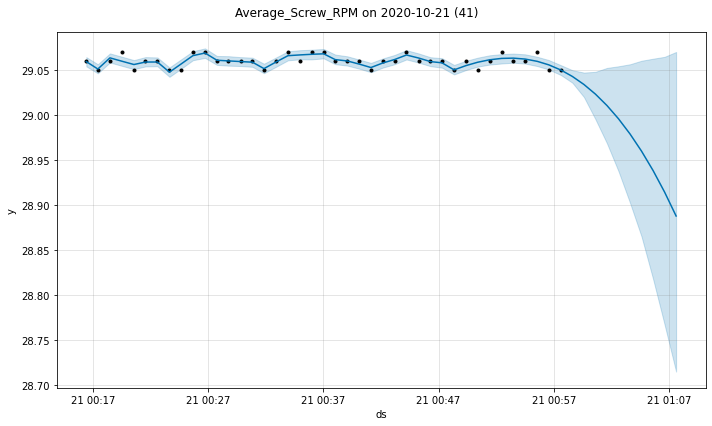

In [163]:
#Plotting for the First Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested

pro = pd.DataFrame()

pro['ds'] = ts1_rg3['TimeStamp']

#The seems to be an error in decimal placement of Average_Screw_RPM value so divide it by 10 to make it uniform with the rest of the data.
# Either way it does not effect the plot
pro['y'] = ts1_rg3['Average_Screw_RPM']/10 

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)

#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Average_Screw_RPM on 2020-10-21 ({})'.format(len(pro)))
fig1.tight_layout()


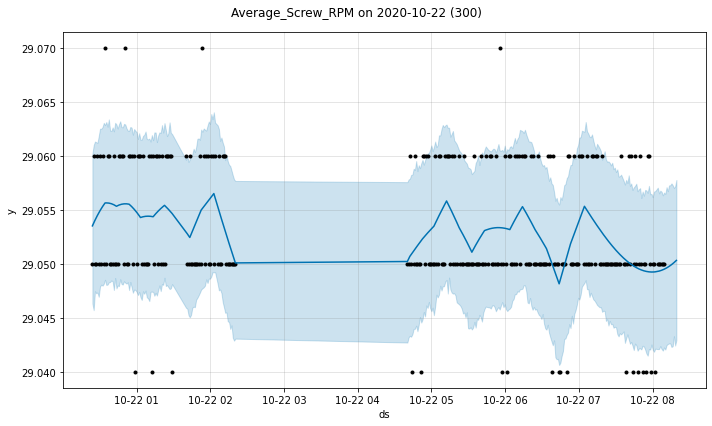

In [164]:
##Plotting for the Second Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts2_rg3['TimeStamp']

#The seems to be an error in decimal placement of Average_Screw_RPM value so divide it by 10 to make it uniform with the rest of the data.
# Either way it does not effect the plot
pro['y'] = ts2_rg3['Average_Screw_RPM']/10 

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Average_Screw_RPM on 2020-10-22 ({})'.format(len(pro)))
fig1.tight_layout()


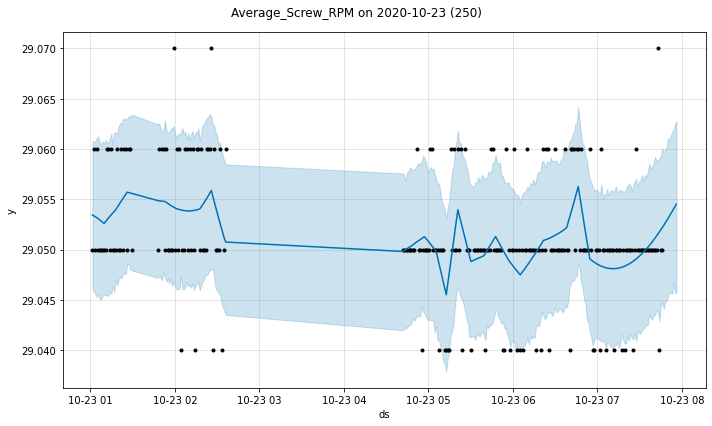

In [165]:
##Plotting for the Third Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts3_rg3['TimeStamp']

#The seems to be an error in decimal placement of Average_Screw_RPM value so divide it by 10 to make it uniform with the rest of the data.
# Either way it does not effect the plot
pro['y'] = ts3_rg3['Average_Screw_RPM']/10 
#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Average_Screw_RPM on 2020-10-23 ({})'.format(len(pro)))
fig1.tight_layout()


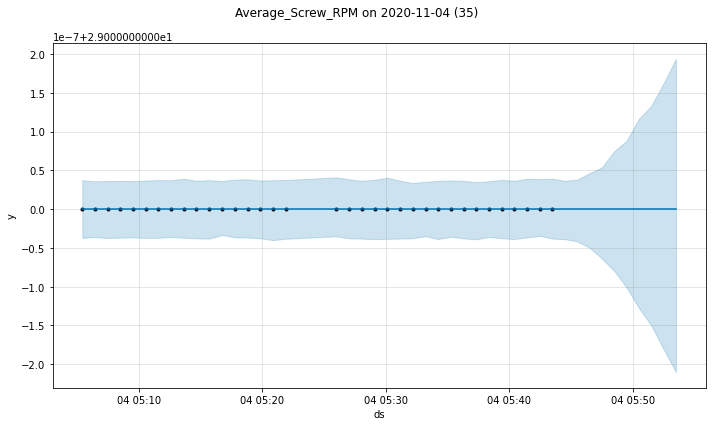

In [166]:
##Plotting for the Fourth Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts4_rg3['TimeStamp']

#The seems to be an error in decimal placement of Average_Screw_RPM value so divide it by 10 to make it uniform with the rest of the data.
# Either way it does not effect the plot
pro['y'] = ts4_rg3['Average_Screw_RPM']/10 

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Average_Screw_RPM on 2020-11-04 ({})'.format(len(pro)))
fig1.tight_layout()


## 시계열별 Plasticizing_Time 예측

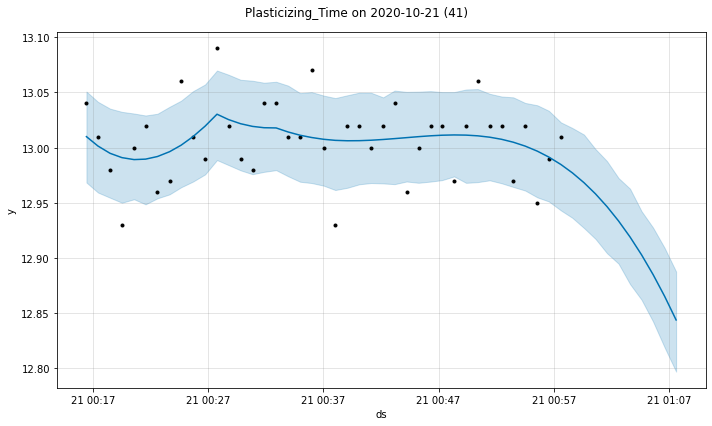

In [167]:
#Plotting for the First Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested

pro = pd.DataFrame()

pro['ds'] = ts1_rg3['TimeStamp']
pro['y'] = ts1_rg3['Plasticizing_Time']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)

#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Plasticizing_Time on 2020-10-21 ({})'.format(len(pro)))
fig1.tight_layout()


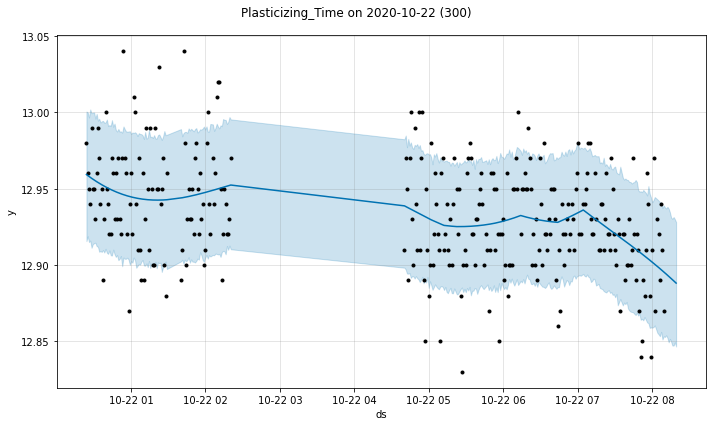

In [168]:
##Plotting for the Second Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts2_rg3['TimeStamp']
pro['y'] = ts2_rg3['Plasticizing_Time']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Plasticizing_Time on 2020-10-22 ({})'.format(len(pro)))
fig1.tight_layout()


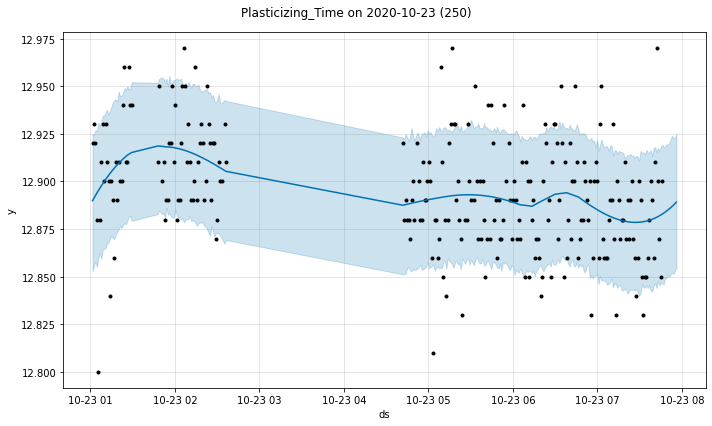

In [169]:
##Plotting for the Third Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts3_rg3['TimeStamp']
pro['y'] = ts3_rg3['Plasticizing_Time']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Plasticizing_Time on 2020-10-23 ({})'.format(len(pro)))
fig1.tight_layout()


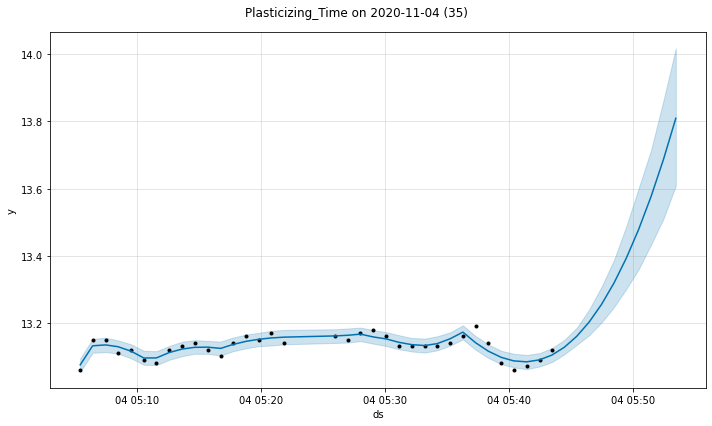

In [170]:
##Plotting for the Fourth Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts4_rg3['TimeStamp']
pro['y'] = ts4_rg3['Plasticizing_Time']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Plasticizing_Time on 2020-11-04 ({})'.format(len(pro)))
fig1.tight_layout()


## 시계열별 Mold_Temperature_3 예측

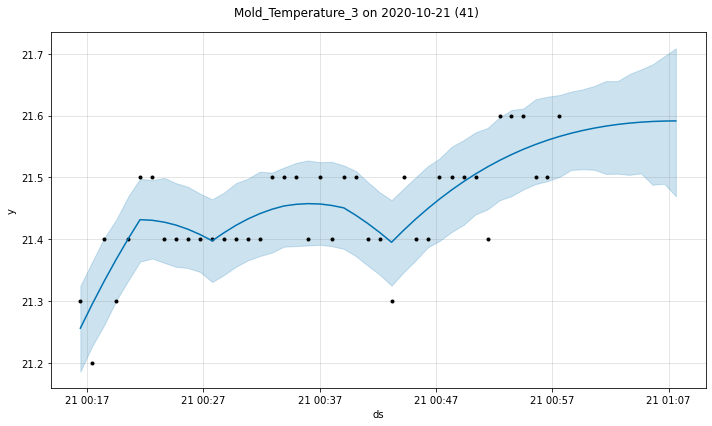

In [171]:
#Plotting for the First Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested

pro = pd.DataFrame()

pro['ds'] = ts1_rg3['TimeStamp']
pro['y'] = ts1_rg3['Mold_Temperature_3']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)

#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Mold_Temperature_3 on 2020-10-21 ({})'.format(len(pro)))
fig1.tight_layout()


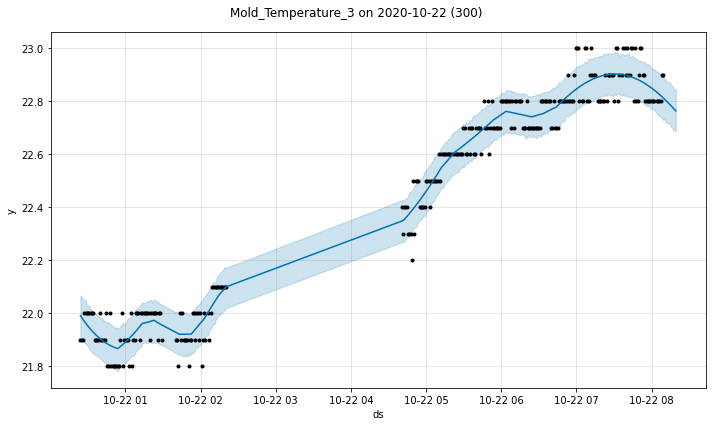

In [172]:
##Plotting for the Second Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts2_rg3['TimeStamp']
pro['y'] = ts2_rg3['Mold_Temperature_3']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Mold_Temperature_3 on 2020-10-22 ({})'.format(len(pro)))
fig1.tight_layout()


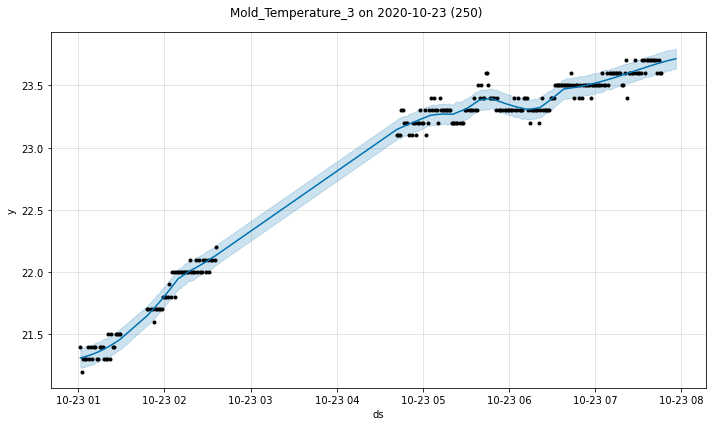

In [173]:
##Plotting for the Third Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts3_rg3['TimeStamp']
pro['y'] = ts3_rg3['Mold_Temperature_3']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Mold_Temperature_3 on 2020-10-23 ({})'.format(len(pro)))
fig1.tight_layout()


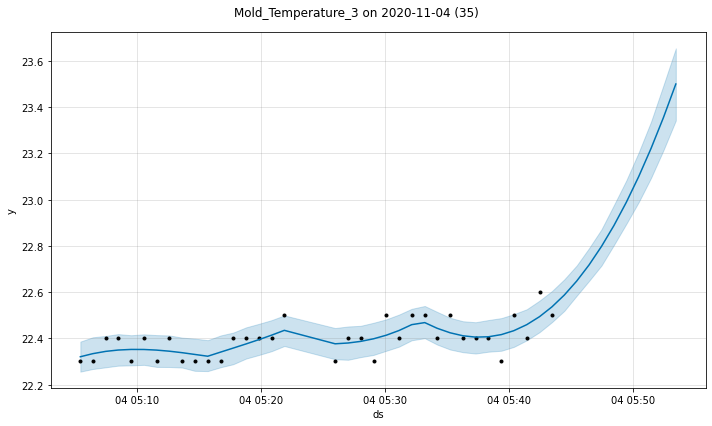

In [174]:
##Plotting for the Fourth Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts4_rg3['TimeStamp']
pro['y'] = ts4_rg3['Mold_Temperature_3']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Mold_Temperature_3 on 2020-11-04 ({})'.format(len(pro)))
fig1.tight_layout()


## 시계열별 Mold_Temperature_4 예측

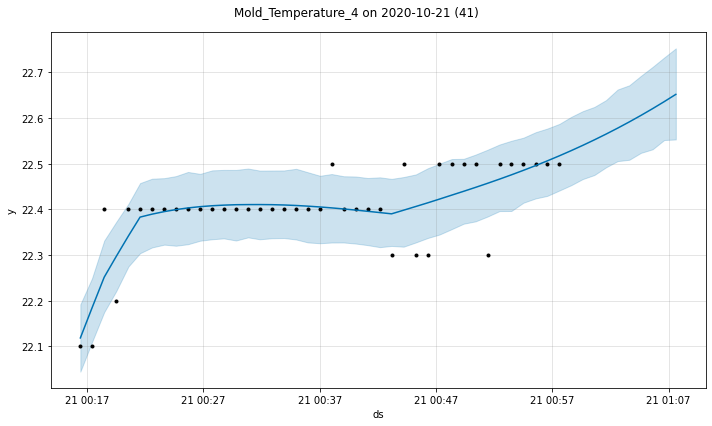

In [175]:
#Plotting for the First Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested

pro = pd.DataFrame()

pro['ds'] = ts1_rg3['TimeStamp']
pro['y'] = ts1_rg3['Mold_Temperature_4']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)

#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Mold_Temperature_4 on 2020-10-21 ({})'.format(len(pro)))
fig1.tight_layout()


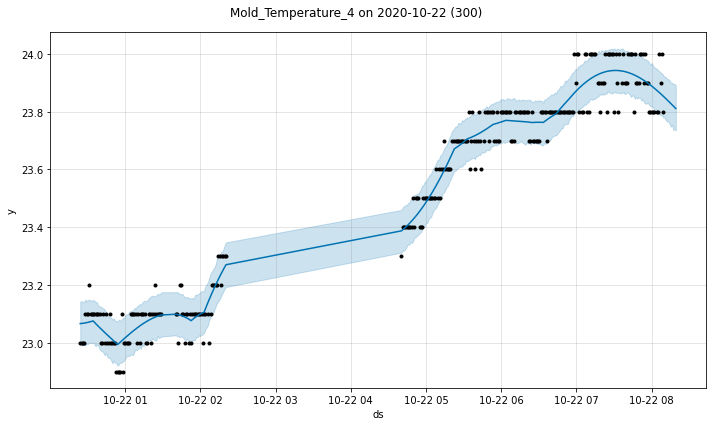

In [176]:
##Plotting for the Second Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts2_rg3['TimeStamp']
pro['y'] = ts2_rg3['Mold_Temperature_4']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Mold_Temperature_4 on 2020-10-22 ({})'.format(len(pro)))
fig1.tight_layout()


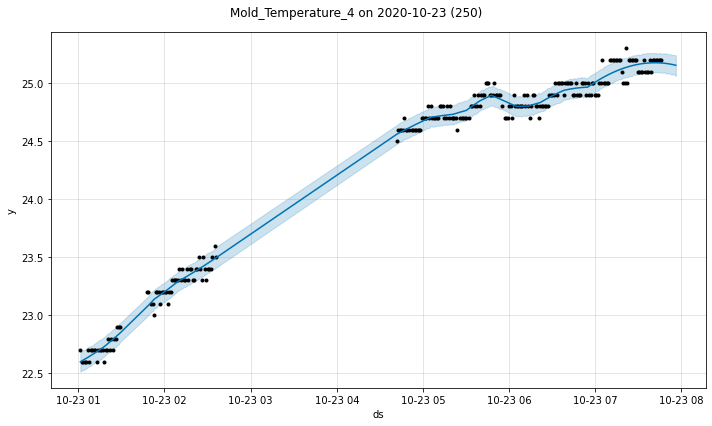

In [177]:
##Plotting for the Third Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts3_rg3['TimeStamp']
pro['y'] = ts3_rg3['Mold_Temperature_4']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Mold_Temperature_4 on 2020-10-23 ({})'.format(len(pro)))
fig1.tight_layout()


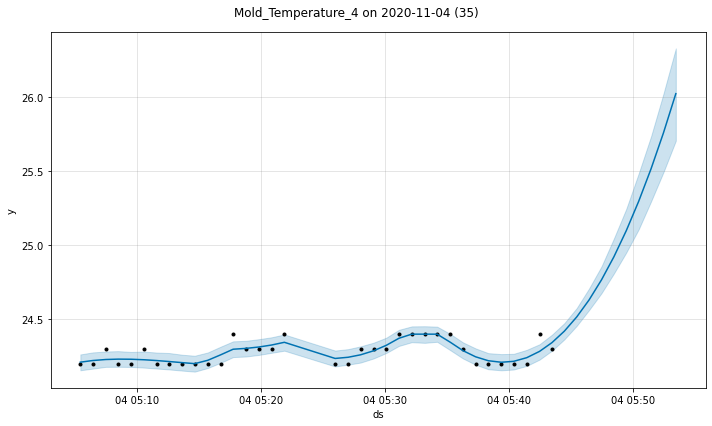

In [178]:
##Plotting for the Fourth Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts4_rg3['TimeStamp']
pro['y'] = ts4_rg3['Mold_Temperature_4']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Mold_Temperature_4 on 2020-11-04 ({})'.format(len(pro)))
fig1.tight_layout()


## 시계열별 Max_Injection_Speed 예측

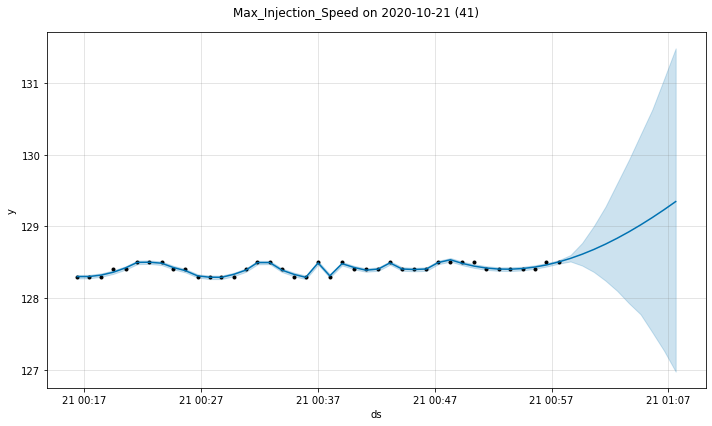

In [179]:
#Plotting for the First Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested

pro = pd.DataFrame()

pro['ds'] = ts1_rg3['TimeStamp']
pro['y'] = ts1_rg3['Max_Injection_Speed']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)

#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Max_Injection_Speed on 2020-10-21 ({})'.format(len(pro)))
fig1.tight_layout()


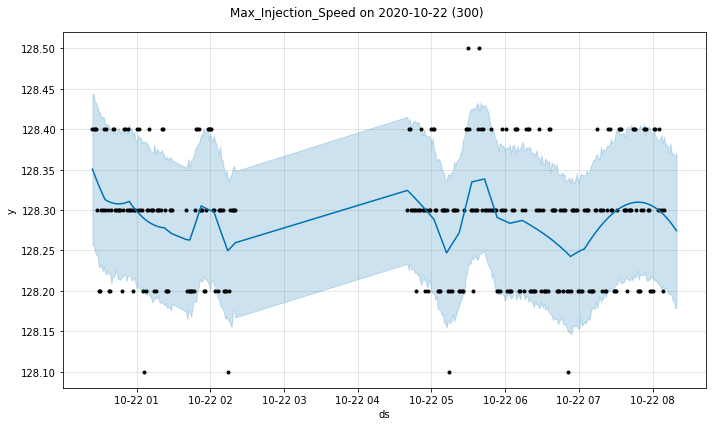

In [180]:
##Plotting for the Second Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts2_rg3['TimeStamp']
pro['y'] = ts2_rg3['Max_Injection_Speed']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Max_Injection_Speed on 2020-10-22 ({})'.format(len(pro)))
fig1.tight_layout()


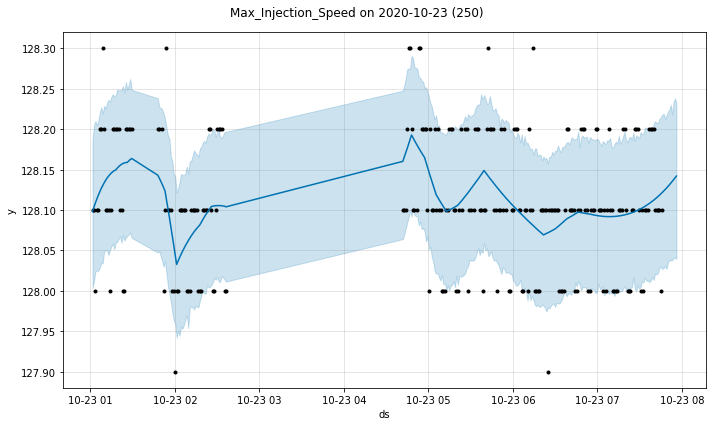

In [181]:
##Plotting for the Third Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts3_rg3['TimeStamp']
pro['y'] = ts3_rg3['Max_Injection_Speed']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Max_Injection_Speed on 2020-10-23 ({})'.format(len(pro)))
fig1.tight_layout()


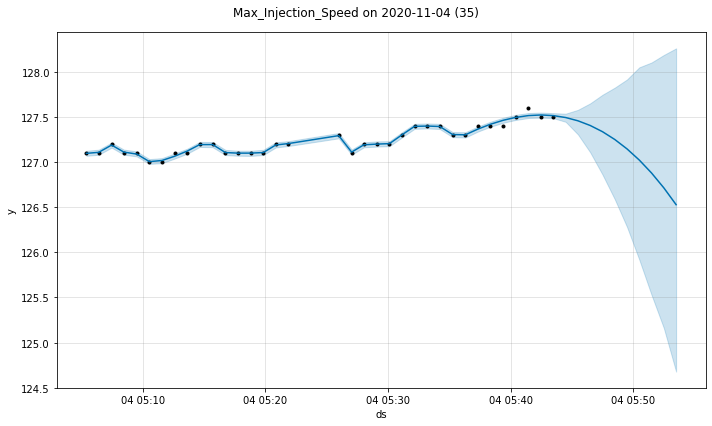

In [182]:
##Plotting for the Fourth Time Series
#creating a new dataframe for prophet with only two columns namely 'ds' for Timestamp and 'y' for the variable
#prophet is strict about the input format, it is important to do it as suggested
pro = pd.DataFrame()

pro['ds'] = ts4_rg3['TimeStamp']
pro['y'] = ts4_rg3['Max_Injection_Speed']

#declaring the model and fitting on the given data
with suppress_stdout_stderr():
    m = Prophet(yearly_seasonality=False,weekly_seasonality=False,daily_seasonality=True)
    m.fit(pro, verbose=2)
    
#making prediction for next 10 timesteps
future = m.make_future_dataframe(periods=10, freq='1min')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

#plotting the forecast with the real values
fig1=m.plot(forecast)
fig1.suptitle('Max_Injection_Speed on 2020-11-04 ({})'.format(len(pro)))
fig1.tight_layout()
